(ch:query)=
# Querying from the Catalog

If WCS(World Coordinate System: converts image XY pixel to, e.g., RA/DEC. See slides 4-7 of [this](http://www.atnf.csiro.au/people/mcalabre/WCS/Intro/WCS01.html), for example) is properly implemented, we should be able to find stars in the image automatically.

``astroquery`` is an [astropy-affiliated python package](https://www.astropy.org/affiliated/) for such query. Here I will demonstrate how to query Pan-STARRS DR2 and Gaia catalog, which are two of the widely used catalogs as of 2023.

We will use [``vizier``](https://astroquery.readthedocs.io/en/latest/vizier/vizier.html) and [``JPLHorizons``](https://astroquery.readthedocs.io/en/latest/jplhorizons/jplhorizons.html) modules.


In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-04-26 19:28:55 (KST = GMT+0900) 


0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.7.0
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.23.2
5 scipy      1.10.1
6 matplotlib 3.7.1
7 astroquery 0.4.7.dev8438
8 photutils  1.6.1.dev103+gad22185f
9 version_information 1.0.4


In [2]:
# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path

import numpy as np

from astropy import units as u
from astropy.nddata import CCDData
from astropy.coordinates import SkyCoord

from astroquery.gaia import Gaia
from astroquery.mast import Catalogs
Gaia.ROW_LIMIT = -1  # no limit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update({'font.size':12})

from photutils.aperture import (CircularAperture, CircularAnnulus, 
                                aperture_photometry, ApertureStats)
from photutils.detection import DAOStarFinder

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

ccd = CCDData.read(allfits[0])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## The Catalogs
[Gaia](https://www.cosmos.esa.int/web/gaia/home) ([Wikipedia](https://en.wikipedia.org/wiki/Gaia_(spacecraft))) is the ESA space mission that is planned to work from 2013-2025. Its main goal is to perform precise astrometry of 1 billion objects. Since it has two passbands, colorimetry has also been performed.

As of 2023, Data Realease 3 (DR3) is the most recent available data set for Gaia.

[Pan-STARRS1](https://outerspace.stsci.edu/display/PANSTARRS/) (also called PS1; [Wikipedia](https://en.wikipedia.org/wiki/Pan-STARRS)) is a ground-based 1.8 m Ritchey-Chredien telescope facility at Hawaii. 

As of 2023, Data Realease 2 (DR2) is the most recent available data set for PS1.


## Archives
There are multiple archive services for large-scale astronomical datasets:

[**VizieR**](https://vizier.unistra.fr/) ([Wikipedia](https://en.wikipedia.org/wiki/VizieR))
:A catalog service run by Université de Strasbourg/CNRS. I feel many people archive their observational results (e.g., galaxy redshift catalog, asteroid polarimetric observation results, etc) to VizieR. Sometimes, for some reasons I cannot understand, large-catalog data are not accessible from VizieR for very long time. Also, the column names in VizieR is always very different from other catalog services. You can go to [here](https://vizier.cfa.harvard.edu/viz-bin/VizieR-2) and search for ``gaia`` or ``ps1`` for instance.


[**MAST**](https://archive.stsci.edu/) (kulski Archive for Space Telescopes; [Wikipedia](https://en.wikipedia.org/wiki/Mikulski_Archive_for_Space_Telescopes))
:A catalog survice run by STScI. I feel MAST mainly goes with space telescope data (HST, JWST, Gaia, TESS, ...). [Two main ground-based mission data are available](https://archive.stsci.edu/missions-and-data), namely Pan-STARRS and VLA-FIRST.

It seems like the most official way to access Gaia is through `astroquery.Gaia` using TAP+ (see [official website](https://www.cosmos.esa.int/web/gaia/data-release-3)'s "PYTHON ACCESS"). Indeed, Gaia DR3 is available only from here, not from MAST.

```{important} 
Before proceed, please read and follow the tutorials of [astroquery/gaia](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html). (only ``1.1. Query object`` and ``1.2. Cone search`` are enough, i.e., ``.query_object_async`` and ``.cone_search_async``)

Also, please skim through [astropy/wcs](https://docs.astropy.org/en/stable/wcs/index.html). You don't have to know the details, but you have to know the basic usages, e.g., the basic usage shown in [astropy/wcs/wcsapi](https://docs.astropy.org/en/stable/wcs/wcsapi.html).
```

## Query Stars in the FoV

Now check if our FITS file (``CCDData``) has WCS information. Since in our observation, the pixel scale is roughly 0.39 arcsec per pixel. Thus, let's query the stars within 
* a circular region (so-called the **cone**) centered at the center of our FoV, radius of ``fov_radius = 0.4*diagonal_length/2``. ← This is because MAST only supports cone search.
* a rectangular region centered at the center of our FoV, width and height of ``0.4*width`` and ``0.4*height``, respectively. ← This is because Gaia.query_object_async supports rectangular query.

In [3]:
print(ccd.wcs)

pix_scale = 0.4*u.arcsec

center_xy = np.array(ccd.shape)/2
center_radec = ccd.wcs.wcs_pix2world(*center_xy, 0)
center_coo = SkyCoord(*center_radec, unit='deg')

width, height = np.array(ccd.shape)*pix_scale

print("\nCoordinate of the center of the image:\n", center_coo)

fov_radius = np.sqrt((np.array(ccd.shape)**2).sum())/2 * pix_scale

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 204.8640878996  -8.991494826739  
CRPIX : -4068.090526349  5085.76507007  
PC1_1 PC1_2  : -0.0001096993846665  -1.593373136163e-06  
PC2_1 PC2_2  : -2.91576786403e-07  0.0001095957848141  
CDELT : 1.0  1.0  
NAXIS : 999  999

Coordinate of the center of the image:
 <SkyCoord (ICRS): (ra, dec) in deg
    (204.36178211, -9.49675272)>


/Users/ysbach/miniforge3/lib/python3.10/site-packages/astropy/wcs/wcs.py:3064: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


In [4]:
# =====
# If you want to use MAST, only DR2 is available as of 2023-04-26. 
# You can uncomment q_gaia line.
# Gaia DR2 needs `version=2`
# q_gaia = Catalogs.query_region(center_coo, radius=fov_radius, catalog="Gaia", version=2) 
# =====

# Set default table as DR3 and GAIA_SOURCE.
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
q_gaia = Gaia.query_object_async(coordinate=center_coo, width=width, height=height)

# PS1 DR2 needs `data_release="dr2"`.
q_ps = Catalogs.query_region(center_coo, radius=fov_radius, catalog="Panstarrs", 
                             data_release="dr2", table="mean")
# Change some column names for convenience.
q_ps["raMean"].name = "ra"
q_ps["decMean"].name = "dec"
q_ps["gMeanPSFMag"].name = "g"
q_ps["rMeanPSFMag"].name = "r"

print("Number of results:",len(q_gaia))
print("Number of results:",len(q_ps))

INFO: Query finished. [astroquery.utils.tap.core]


Number of results: 75
Number of results: 5907


In [5]:
print("Number of columns in Gaia, PS1:", len(q_gaia.colnames), len(q_ps.colnames))

Number of columns in Gaia, PS1: 153 125


### Gaia DR3
Note that Gaia DR3 GAIA_SOURCES has 153 columns! The detailed explanation of this table (``GAIA_SOURCE`` table) in DR3 is available [here](https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_main_source_catalogue/ssec_dm_gaia_source.html). What we need are only RA, DEC, and magnitude information. For the magnitudes, the magnitude conversion methods for DR3 are given [here](https://gea.esac.esa.int/archive/documentation/GDR3/Data_processing/chap_cu5pho/cu5pho_sec_photSystem/cu5pho_ssec_photRelations.html):

$$
G - V = -0.02704 + 0.01424C - 0.2156 C^2 + 0.01426 C^3 
$$

using 96413 sources ($\sigma = 0.03017$) and $C := G_\mathrm{BP} - G_\mathrm{RP}$ color. The equation above is applicable to $-0.5 < C < 5.0$.


```{note}
:class: dropdown
If you remember the error analysis in statistics class or theoretical part of this lecture, you may remember the uncertainty of the flux is roughly Gaussian (Poisson distribution in the limiting case). However, the magnitude is calculated by taking a logarithm to this flux. That means, the uncertainty in magnitude is not Gaussian, rigorously speaking, and the error-bars are inherently and expectedly **asymmetric**. Because of this, GAIA team refuses to provide any "magnitude error" value, but only provide the "flux error" value. 

This is a bit annoying for most astronomers because we want to use simple error-bar for magnitudes. However, at the same time, I feel this is a declaration that astronomy is now going into a branch of precise science, not grossly approximating the asymmetric error-bar into a single number.
```

```{warning} 
When you load FITS by ``CCDData.read``, the WCS related information *in the header* will be **deleted**. Hence, you must use ``ccd.wcs`` to access the WCS information. In other words, ``WCS(ccd.header)`` will give empty WCS. This is a bit confusing, since you had to use ``WCS(hdu.header)`` in case of ``HDU`` object, as you practiced. When saving the ``CCDData`` back, WCS-related headers will be re-added. 
```

For error analysis, note that, from Pogson's formula:

$$
C = G_\mathrm{BP} - G_\mathrm{RP} = -2.5 \lg \frac{I_\mathrm{BP}}{I_\mathrm{RP}}
$$

(I is flux). Thus, ignoring any covariance, a simple error propagation gives

$$
\Delta C \approx \frac{2.5}{\ln 10} \sqrt{ \left( \frac{dI_\mathrm{BP}}{I_\mathrm{BP}} \right)^2 + \left( \frac{dI_\mathrm{RP}}{I_\mathrm{RP}} \right)^2 }
$$

and

$$
\Delta V = \sqrt{ (\Delta G)^2 + (0.01424 - 2 \times 0.2156 C + 3 \times 0.01426 C^2)^2 (\Delta C)^2 }
$$

And you may also include the RMS error $\sigma = 0.03017$ with that.

In [6]:
coef = np.array([-0.02704, 0.1425, -0.2156, 0.01426])
rmse = 0.03017
color = q_gaia["bp_rp"]

# Add useful columns
q_gaia["bp_snr"] = 1/q_gaia["phot_bp_mean_flux_over_error"]
q_gaia["rp_snr"] = 1/q_gaia["phot_rp_mean_flux_over_error"]
q_gaia["g_snr"] = 1/q_gaia["phot_g_mean_flux_over_error"]

# Calculate color error
q_gaia["dC"] = 2.5/np.log(10)*np.sqrt((q_gaia["rp_snr"])**2 + (q_gaia["bp_snr"])**2)

# Calculate V-mag and error
q_gaia["V"] = (
    q_gaia["phot_g_mean_mag"]
    + coef[0] + coef[1]*color + coef[2]*color**2 + coef[3]*color**3
)
q_gaia["dV"] = np.sqrt(
    2.5/np.log(10)*q_gaia["g_snr"]**2
    + (coef[1] + 2*coef[2]*color + 3*coef[3]*color**2)**2*q_gaia["dC"]**2
    + rmse**2
)

# Only select stars with good color
mask = (-0.5 < color) & (color < 5)
q1 = q_gaia["ra", "dec", "bp_rp", "g_snr", "bp_snr", "rp_snr", "dC", "V", "dV"][mask]

# Calculate x, y position
coo = SkyCoord(q1["ra"], q1["dec"], unit='deg')
q1["x"], q1["y"] = ccd.wcs.wcs_world2pix(coo.ra, coo.dec, 0)

# Remove stars outside the image
q1 = q1[(q1["x"] > 10) & (q1["x"] < ccd.shape[1]-10) 
        & (q1["y"] > 10) & (q1["y"] < ccd.shape[0]-10)]

# print
print(f"Total {len(q1)} stars")
q1.round(3)
q1


Total 65 stars


ra,dec,bp_rp,g_snr,bp_snr,rp_snr,dC,V,dV,x,y
deg,deg,mag,,,,,,,,
float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64
204.352,-9.504,0.732,0.016,0.139,0.188,0.254,20.859,0.051,586.313,435.758
204.373,-9.505,2.855,0.002,0.033,0.004,0.036,16.681,0.041,399.077,428.649
204.373,-9.505,2.871,0.006,0.016,0.01,0.02,16.781,0.034,399.015,427.491
204.373,-9.505,2.748,0.005,0.245,0.087,0.282,19.131,0.205,403.101,420.853
204.35,-9.508,1.956,0.004,0.13,0.051,0.152,19.712,0.087,607.765,395.122
204.378,-9.502,0.28,0.003,0.035,0.058,0.073,19.432,0.03,355.88,450.611
204.34,-9.486,2.01,0.003,0.092,0.032,0.106,19.125,0.066,692.754,596.982
204.343,-9.514,2.116,0.005,0.116,0.037,0.132,19.665,0.082,669.384,345.025


### Pan-STARRS1 DR2
It seems like there are three tables available from PS1 web query API (e.g., [this notebook](http://ps1images.stsci.edu/ps1_dr2_api.html)): "mean", "stack", and "detection". All the metadata can be found based on the url (see `ps1metadata` function), e.g., [this link](https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr1/mean/metadata) for the metadata of mean table.

According to [Tonry+12](https://ui.adsabs.harvard.edu/abs/2012ApJ...750...99T),

$$
V - r = 0.006 + 0.474(g-r) \quad\rightarrow\quad V = 0.006 + 0.474g + 0.526r \quad (\pm 0.012)
\\
R - r = -0.138 - 0.131(g-r) \quad\rightarrow\quad R = -0.138 -0.131g + 1.131 r \quad (\pm 0.015)
$$

where g, r are the g- and r-band magnitudes in PS1 filter system, respectively. Thus,

$$
\Delta V = \sqrt{ (0.474 \Delta g)^2 + (0.526 \Delta r)^2 } 
\\
\Delta R = \sqrt{ (0.131 \Delta g)^2 + (1.131 \Delta r)^2 }
$$

And you may also include the RMS error $\sigma = 0.012$ or $0.015$ with that.

In real science case, you must remove galaxies for differential photometry (maybe discussed later). Here, we will ignore it.

In [7]:
# drop stars with unknown magnitudes
q_ps = q_ps.to_pandas().dropna(subset=["g", "r"])

# Calculate V and R
q_ps["V"] = 0.006 + 0.474*q_ps["g"] + 0.526*q_ps["r"]
q_ps["R"] = -0.138 - 0.131*q_ps["g"] + 1.131*q_ps["r"]
q_ps["dV"] = np.sqrt(
    0.474**2*q_ps["gMeanPSFMagErr"]**2 
    + 0.526**2*q_ps["rMeanPSFMagErr"]**2 + 0.012**2
)
q_ps["dR"] = np.sqrt(
    0.131**2*q_ps["gMeanPSFMagErr"]**2
    + 1.131**2*q_ps["rMeanPSFMagErr"]**2 + 0.015**2
)

# Select only important columns
q2 = q_ps[["ra", "dec", "g", "r", "V", "R", "dV", "dR"]].copy().reset_index(drop=True)

# Select only brighter than 22 mag
q2 = q2[(q2["V"] < 22) & (q2["R"] < 22)].copy().reset_index(drop=True)

# Calculate x, y position
coo = SkyCoord(q2["ra"], q2["dec"], unit='deg')
q2["x"], q2["y"] = ccd.wcs.wcs_world2pix(coo.ra, coo.dec, 0)

# Remove stars outside the image
q2 = q2[(q2["x"] > 10) & (q2["x"] < ccd.shape[1]-10) 
        & (q2["y"] > 10) & (q2["y"] < ccd.shape[0]-10)]

# print
print(f"Total {len(q2)} stars")
q2.round(3)
q2

Total 126 stars


,ra,dec,g,r,V,R,dV,dR,x,y
2,204.410444,-9.543147,19.949100,19.042500,19.478228,18.785735,0.021401,0.031288,68.791659,76.814691
4,204.313122,-9.517118,20.951200,20.234800,20.580374,20.002952,0.023930,0.027035,938.166977,315.222076
5,204.322624,-9.524781,18.504400,17.985399,18.237406,17.779410,0.012597,0.016538,853.773794,245.408823
6,204.387721,-9.502643,22.124399,21.484301,21.793707,21.262448,0.079612,0.109307,267.797195,445.429511
7,204.413848,-9.503995,22.077999,21.634600,21.850771,21.438514,0.109889,0.135453,34.077485,432.497826
...,...,...,...,...,...,...,...,...,...,...
191,204.352190,-9.466705,19.158899,18.009300,18.560210,17.720703,0.013098,0.016917,582.191122,772.542005
192,204.385610,-9.445685,21.233101,20.859301,21.042482,20.672333,0.028622,0.053270,280.660857,962.402604
193,204.391725,-9.449751,21.913401,19.827200,20.822059,19.415908,0.114143,0.057990,226.350935,925.358571
194,204.391725,-9.449731,20.910900,19.654699,20.256139,19.352137,0.023311,0.034164,226.344244,925.539059


Note that ``q2`` is in ``pandas.DataFrame`` and ``q1`` is ``astropy.Table``.

### Comparing two catalogs

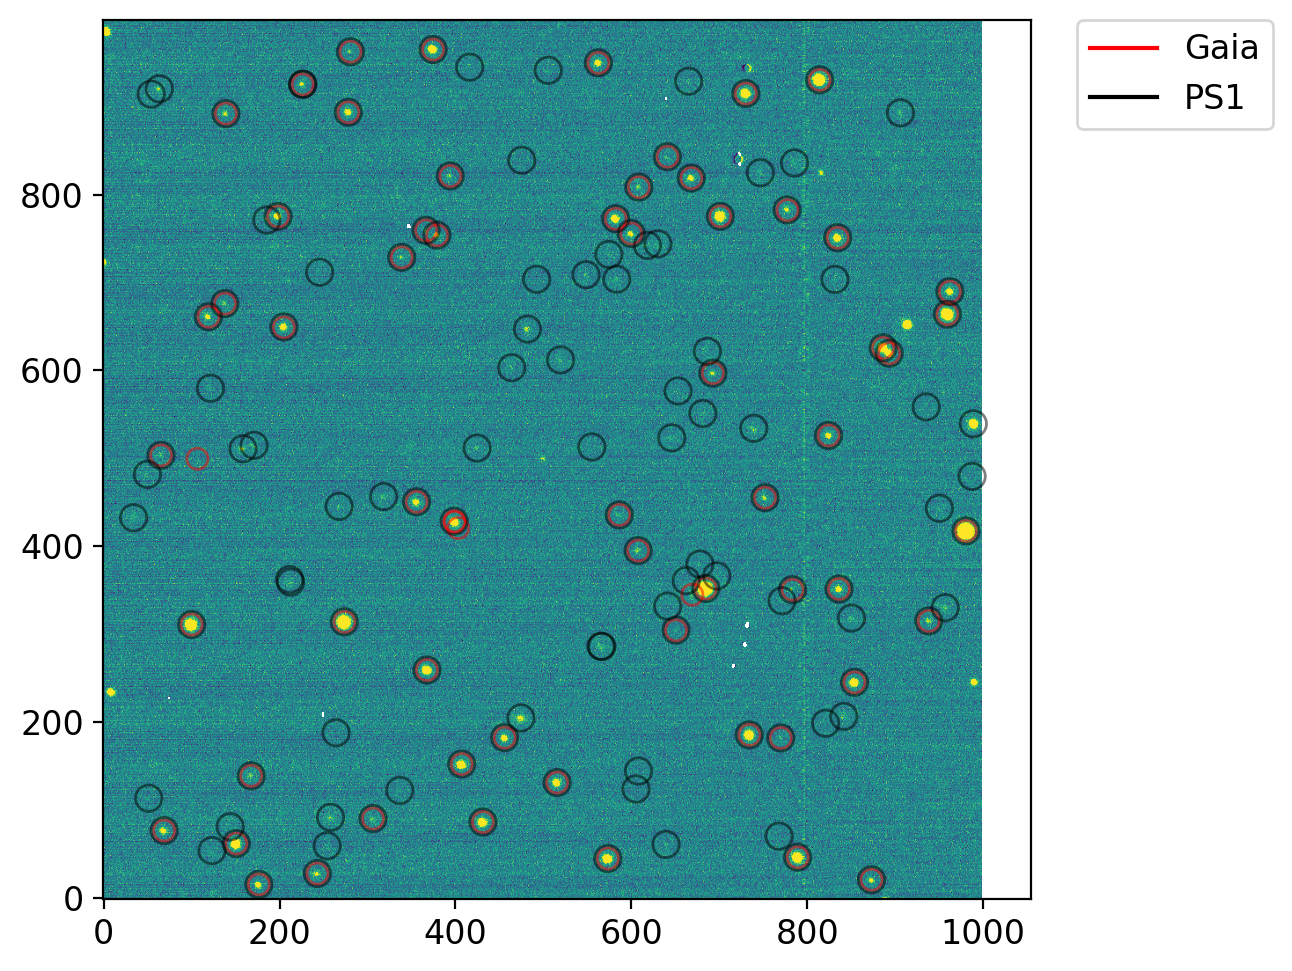

In [8]:
aps1 = CircularAperture(np.array([q1["x"], q1["y"]]).T, r=12)
aps2 = CircularAperture(np.array([q2["x"], q2["y"]]).T, r=15)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, ccd, zscale=True)
aps1.plot(color='r', lw=1, alpha=0.5, ax=axs)
aps2.plot(color='k', lw=1, alpha=0.5, ax=axs)

for c, l in zip("rk", ["Gaia", "PS1"]):
    axs.plot(np.nan, np.nan, f"{c}", label=l)
axs.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show();

### A Short Discussion

Note that there are more objects in PS1 than Gaia. Since Gaia's main purpose is astrometry, it is not surprising that PS1 is sensing more celestial objects. Also, PS1 has the filter system that is closer to the classical filter systems (it uses grizy). Thus, for ground-based differential photometry, PS1 catalog will be more useful.